# Unsupervised Learning Using K-Means Clustering on California Housing Data

In this assignment, we will utilize the MNIST dataset to develop a deep Multi-Layer Perceptron (MLP) mode. Our goal is to apply the Keras Tuner to find the best hyperparameter to optimize the MLP model's performance, aiming to achieve a test accuracy of at least 98%. 

In this notebook, we will:

1. Train a Deep MLP Model on the MNIST Dataset: Set up a deep MLP model for classifying handwritten digits from the MNIST dataset. 
2. Hyperparameter Tuning with Keras Tuner: Use Keras Tuner to perform hyperparameter tuning on the model. Search for optimal values of key hyperparameters, such as, number of Hidden Layers and units in a hidden layer, learning rate, and batch size. Configure Keras Tuner to use Random Search to find the best hyperparameter values.
3. Analyze the Tuning Results: Once tuning is complete, evaluate the model’s performance with the best-found hyperparameters on the test set. Present results, including metrics such as accuracy, training time, and convergence rate. Discuss the chosen hyperparameters and explain how they contributed to achieving high accuracy on the MNIST dataset.
4. Comparison with Baseline Model (Optional) Optionally, compare the tuned MLP model's accuracy with the models we used for classification in our early labs on classification for MNIST dataset. Analyze and discuss the improvement in the performance.


# Preparation

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)


# Prepare the MNIST dataset

In [2]:
# MNIST data is loaded, normalized, and split into training, validation, and test sets
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

X_train_full = X_train_full / 255.0

X_test = X_test / 255.0
# (10000, 28, 28)

X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
# (5000, 28, 28), (55000, 28, 28)

y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
# (5000,), (55000,)

# Train a Deep MLP Model on the MNIST Dataset:

In [3]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

In [4]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(512, activation="relu"),  # Increased units
    keras.layers.Dropout(0.2),  # Dropout to prevent overfitting
    keras.layers.Dense(256, activation="relu"),  # Additional layer with units
    keras.layers.Dropout(0.2),
    keras.layers.Dense(128, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [5]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 512)               401920    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 10)                1

In [6]:
# We will start with a small learning rate of 1e-3
# and grow it by 0.5% at each iteration:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=3e-1),
              metrics=["accuracy"])

In [7]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)

history = model.fit(
    X_train, y_train, 
    epochs=30,
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

Epoch 1/30
 613/1719 [=========>....................] - ETA: 8s - loss: 0.4809 - accuracy: 0.8521

KeyboardInterrupt: 

In [ ]:
model = keras.models.load_model("my_mnist_model.h5")
test_loss, test_accuracy = model.evaluate(X_test, y_test)
# Test set accuracy of at least 98%
print(f"Test accuracy: {test_accuracy*100:.2f}%")
print(f"Test loss: {test_loss:.5f}")

313/313 [==============================] - 2s 5ms/step - loss: 0.0695 - accuracy: 0.9804
Test accuracy: 98.04%
Test loss: 0.06946


# Hyperparameter Tuning with Keras Tuner: 

In [7]:
from keras_tuner import HyperParameters
from keras_tuner.tuners import RandomSearch
import keras

def build_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[28, 28]))
    
    # Tune the number of hidden layers and the units in each layer
    for i in range(hp.Int('num_layers', 1, 2)):  # Allow up to 2 dense layers
        model.add(keras.layers.Dense(
            units=hp.Int('units_' + str(i), min_value=128, max_value=512, step=64),
            activation='relu'
        ))
        
        # Tune dropout rate for each hidden layer
        model.add(keras.layers.Dropout(rate=hp.Float('dropout_' + str(i), 0.1, 0.3, step=0.1)))

    model.add(keras.layers.Dense(10, activation='softmax'))
    
    # Tune the learning rate
    model.compile(
        optimizer=keras.optimizers.SGD(
            learning_rate=hp.Float('learning_rate', 1e-3, 5e-2, sampling='log')
        ),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

In [8]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Increase to allow more diverse searches
    # executions_per_trial=2,  # Average over 2 executions for stability
    directory='my_mnist_tuning',
    project_name='mnist_mlp_tuning'
)

In [9]:
early_stopping_cb_tuned = keras.callbacks.EarlyStopping(patience=10)
checkpoint_cb_tuned = keras.callbacks.ModelCheckpoint("my_mnist_tuned_model.h5", save_best_only=True)

tuner.search(X_train, y_train,
             epochs=30,  # Increase epochs for convergence
             validation_data=(X_valid, y_valid),
             callbacks=[checkpoint_cb_tuned, early_stopping_cb_tuned])


Trial 5 Complete [00h 04m 33s]
val_accuracy: 0.9634000062942505

Best val_accuracy So Far: 0.9855999946594238
Total elapsed time: 00h 33m 05s


In [ ]:
# Display the 5 hyperparameter configurations
tuner.results_summary(num_trials=5)

Results summary
Results in my_mnist_tuning\mnist_mlp_tuning
Showing 5 best trials
Objective(name="val_accuracy", direction="max")

Trial 3 summary
Hyperparameters:
num_layers: 2
units_0: 320
dropout_0: 0.2
learning_rate: 0.03815027095807347
units_1: 192
dropout_1: 0.1
Score: 0.9855999946594238

Trial 2 summary
Hyperparameters:
num_layers: 2
units_0: 384
dropout_0: 0.1
learning_rate: 0.02199124399452183
units_1: 128
dropout_1: 0.1
Score: 0.9847999811172485

Trial 1 summary
Hyperparameters:
num_layers: 1
units_0: 512
dropout_0: 0.2
learning_rate: 0.009223472063223423
Score: 0.9769999980926514

Trial 4 summary
Hyperparameters:
num_layers: 1
units_0: 192
dropout_0: 0.1
learning_rate: 0.0045053153662651365
units_1: 512
dropout_1: 0.1
Score: 0.9634000062942505

Trial 0 summary
Hyperparameters:
num_layers: 1
units_0: 448
dropout_0: 0.1
learning_rate: 0.0014135525492727336
Score: 0.9413999915122986


# Analyze the Tuning Results:

In [12]:
model_tuned_test = tuner.get_best_models(num_models=1)[0]
test_loss_tuned, test_accuracy_tuned = model_tuned_test.evaluate(X_test, y_test)
# Test set accuracy of at least 98%
print(f"Test accuracy: {test_accuracy_tuned*100:.2f}%")
print(f"Test loss: {test_loss_tuned:.5f}")

313/313 [==============================] - 2s 4ms/step - loss: 0.0573 - accuracy: 0.9816
Test accuracy: 98.16%
Test loss: 0.05728


In [13]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for param in best_hp.values:
    print(f"{param}: {best_hp.get(param)}")


Best Hyperparameters:
num_layers: 2
units_0: 320
dropout_0: 0.2
learning_rate: 0.03815027095807347
units_1: 192
dropout_1: 0.1


In [26]:
import time

# Rebuild and train the model with the best hyperparameters
best_model = build_model(best_hp)  # use the `build_model` function with the best HPs

# Capture history when retraining the model with best hyperparameters
history = best_model.fit(
    X_train, y_train,
    epochs=30,  # Adjust as needed
    validation_data=(X_valid, y_valid),
    callbacks=[checkpoint_cb, early_stopping_cb]
)

# Now you can access the training history from `history` for analysis
start_time = time.time()  # Start timing
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
end_time = time.time()  # End timing

training_time = end_time - start_time  # In seconds

# Print results
print(f"Best Validation Accuracy from History: {max(history.history['val_accuracy']):.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"Test Loss: {test_loss:.5f}")
print(f"Total Evaluation Time: {training_time:.2f} seconds")

Epoch 1/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.4147 - accuracy: 0.8782 - val_loss: 0.1896 - val_accuracy: 0.9492
Epoch 2/30
1719/1719 [==============================] - 11s 6ms/step - loss: 0.1960 - accuracy: 0.9418 - val_loss: 0.1334 - val_accuracy: 0.9630
Epoch 3/30
1719/1719 [==============================] - 14s 8ms/step - loss: 0.1436 - accuracy: 0.9582 - val_loss: 0.1024 - val_accuracy: 0.9712
Epoch 4/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1159 - accuracy: 0.9658 - val_loss: 0.0896 - val_accuracy: 0.9742
Epoch 5/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.1002 - accuracy: 0.9705 - val_loss: 0.0820 - val_accuracy: 0.9758
Epoch 6/30
1719/1719 [==============================] - 10s 6ms/step - loss: 0.0848 - accuracy: 0.9746 - val_loss: 0.0761 - val_accuracy: 0.9788
Epoch 7/30
1719/1719 [==============================] - 9s 5ms/step - loss: 0.0742 - accuracy: 0.9777 - val_loss: 0.0739 - val_acc

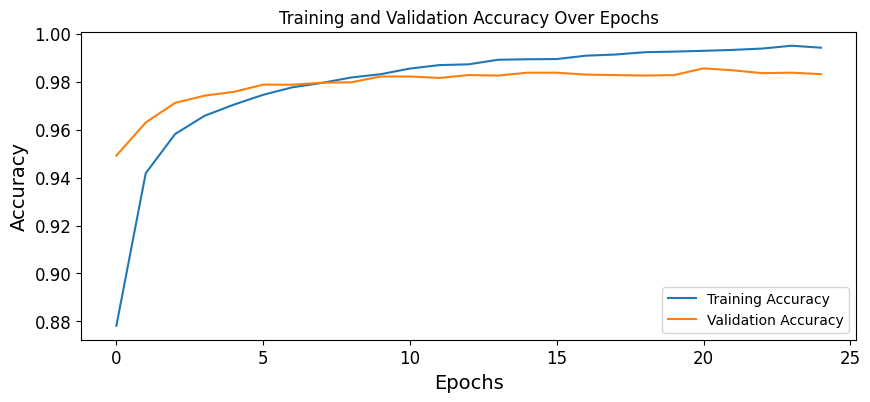

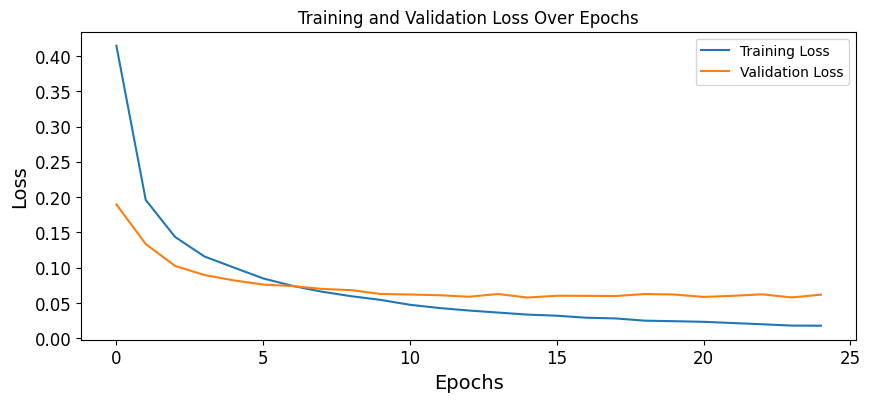

In [27]:
# Plot accuracy over epochs
plt.figure(figsize=(10, 4))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy Over Epochs')
plt.legend()
plt.show()

# Plot loss over epochs
plt.figure(figsize=(10, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


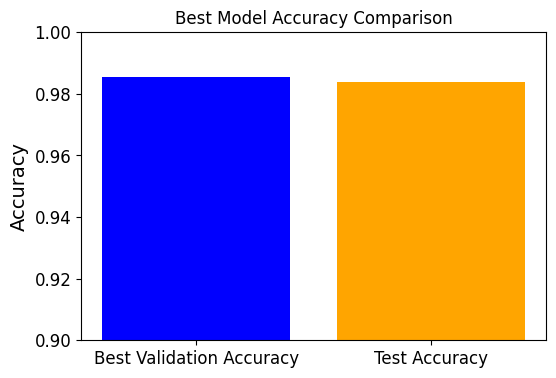

In [32]:
metrics = ['Best Validation Accuracy', 'Test Accuracy']
best_val_accuracy = max(history.history['val_accuracy'])
values = [best_val_accuracy, test_accuracy]

plt.figure(figsize=(6, 4))
plt.bar(metrics, values, color=['blue', 'orange'])
plt.ylim(0.9, 1)  # Set limits for better comparison
plt.ylabel('Accuracy')
plt.title('Best Model Accuracy Comparison')
plt.show()


In [30]:
print(f"Total Training Time for Best Model: {training_time:.2f} seconds")

Total Training Time for Best Model: 1.62 seconds
